In [ ]:
!pip install nbimporter

In [1]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# import torch.nn.init as init
from torch.autograd import Variable
from dataLoader import loadData

In [2]:
# # Downloading Movielens-1m
# !curl -O http://files.grouplens.org/datasets/movielens/ml-1m.zip
# #     http://www.grouplens.org/system/files/ml-1m.zip
# !unzip ml-1m.zip
# !cd ml-1m/

In [3]:
# import zipfile
# with zipfile.ZipFile('ml-1m.zip', 'r') as zip_ref:
#     zip_ref.extractall('./')

In [4]:
seed = 47
np.random.seed(seed)

In [5]:
# load data
tr, vr = loadData('./ml-1m/ratings.dat', delimiter='::', seed=seed, transpose=False, valfrac=0.1)

reading data...
data read in 4.7516655921936035 seconds
loaded dense data matrix


In [6]:
np.save('./tr_movielens_1m', tr)
np.save('./vr_movielens_1m', vr)

In [7]:
tr

array([[5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [3., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [8]:
vr

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [9]:
def get_sparsity(mat):
    sparsity = float(len(mat.nonzero()[0]))
    sparsity /= (mat.shape[0] * mat.shape[1])
    sparsity *= 100
    return sparsity

In [10]:
get_sparsity(tr)

4.021525859265269

In [11]:
get_sparsity(vr)

0.44683670296601535

In [12]:
train = tr.copy()

In [13]:
if torch.cuda.is_available() == True:
    device = "cuda"
else:
    device = "cpu"

# Training Denoising Autoencoder

In [ ]:
############## Pytorch model doesn't converge - to do - check #################

from keras.optimizers import Adam
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras import regularizers

def autoEncoder(X):
    '''
    Autoencoder for Collaborative Filter Model
    '''

    # Input
    input_layer = Input(shape=(X.shape[1],), name='UserScore')
    
    # Encoder
    # -----------------------------
    enc = Dense(512, activation='selu', name='EncLayer1', kernel_regularizer=regularizers.l2(0.000001))(input_layer)

    # Latent Space
    # -----------------------------
    lat_space = Dense(512, activation='selu', name='LatentSpace', kernel_regularizer=regularizers.l2(0.000001))(enc)
    lat_space = Dropout(0.5, name='Dropout')(lat_space) # Dropout

    # Decoder
    # -----------------------------
    dec = Dense(512, activation='selu', name='DecLayer1', kernel_regularizer=regularizers.l2(0.000001))(lat_space)

    # Output
    output_layer = Dense(X.shape[1], activation='linear', name='UserScorePred', kernel_regularizer=regularizers.l2(0.000001))(dec)

    # this model maps an input to its reconstruction
    model = Model(input_layer, output_layer)    
    
    return model

In [ ]:
zero_mask = (train == 0)
positive_feedback_mask = (train > 3)
negative_feedback_mask = ((train < 4) * (1 - zero_mask))

In [ ]:
assert (positive_feedback_mask + negative_feedback_mask != zero_mask).all()
assert (positive_feedback_mask + negative_feedback_mask == 1 - zero_mask).all()

In [ ]:
get_sparsity(zero_mask), get_sparsity(positive_feedback_mask), get_sparsity(negative_feedback_mask)

In [ ]:
100 - get_sparsity(zero_mask), get_sparsity(positive_feedback_mask) + get_sparsity(negative_feedback_mask)

In [ ]:
P = 0.4
mask_arr = (np.random.rand(negative_feedback_mask.shape[0], negative_feedback_mask.shape[1]) > P)
y = negative_feedback_mask
X = negative_feedback_mask*mask_arr

In [ ]:
get_sparsity(X), get_sparsity(y)

In [ ]:
model = autoEncoder(X)
model.compile(optimizer = Adam(lr=0.0001), loss='mse')
model.summary()

In [14]:
predicted_tr = np.load('predicted_tr.npy')
augmented_train = np.load('augmented_train.npy')

In [15]:
# hist = model.fit(x=X, y=y,
#                   epochs=300,
#                   batch_size=128,
#                   shuffle=True,
#                   validation_split=0.0)

In [ ]:
import matplotlib.pyplot as plt 

def plot_hist(hist):
    # summarize history for loss
    fig, ax = plt.subplots()  # create figure & 1 axis

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    plt.plot(hist.history['loss'])
    #plt.plot(hist.history['val_loss'])

plot_hist(hist)

In [ ]:
np.set_printoptions(precision=3)
predicted_tr = model.predict(X)

In [ ]:
(predicted_tr > 0.4).sum(), (y == 1).sum() # predicted vs real

In [ ]:
(X>0.5).sum() # trained on

In [ ]:
(y * (predicted_tr>0.4)).sum()/(predicted_tr>0.4).sum() # accuracy on actual 

In [ ]:
(y * (predicted_tr>0.5)).sum()/((predicted_tr>0.5).sum())

In [ ]:
((predicted_tr>0.5)  * (X<0.5)).sum() # predicted values which were not in the train matrix

In [ ]:
((y * (((predicted_tr>0.5)  * (X<0.5)))) == 1).sum()/(((predicted_tr>0.5)  * (X<0.5))).sum()

In [ ]:
augmented_train = model.predict(y)

In [ ]:
(augmented_train>0.5).sum()

In [ ]:
(y* (augmented_train>0.8)).sum()/(((augmented_train>0.8)).sum())

In [ ]:
threshold = 0.3

In [ ]:
((augmented_train > threshold) * (tr==0)).sum() # new values

In [ ]:
p_probs = [(tr == 1).sum()/((tr > 0) & (tr < 4)).sum(), (tr == 2).sum()/(((tr > 0) & (tr < 4))).sum(), (tr == 3).sum()/((tr > 0) & (tr < 4)).sum()]
p_probs

In [ ]:
augmented_train = tr + (predicted_tr > threshold) * (tr == 0) * np.random.choice(np.arange(1, 4), tr.shape, p=p_probs)

In [16]:
get_sparsity(tr), get_sparsity(augmented_train)

(4.021525859265269, 4.134020185630605)

In [17]:
(np.isin(tr, augmented_train)).all()

True

In [18]:
((tr == 0) * (augmented_train > 0)).sum()

25181

In [ ]:
np.save('predicted_tr', predicted_tr)
np.save('augmented_train', augmented_train)

In [19]:
# gen_iterations = 5
lrD = 5e-4
lrG = 5e-4
batch_size = 64
d_iter = 5
g_iter = 1
nz = 16
lamba = 1e-3
features_length = train.shape[1]
class NetD(torch.nn.Module):
    def __init__(self, use_cuda=True):
        super(NetD, self).__init__()
        self.use_cuda = use_cuda
        # top
        self.t1 = torch.nn.Linear(features_length, 1024)
        # bottom
        self.b1 = torch.nn.Linear(features_length, 1024)
        # combined
        self.fc = torch.nn.Linear(2 * 1024, features_length)
    def forward(self, xr, xf):
        # get filt
#         filt = (torch.abs((real > 0.3).float() * fake - real))/real.shape[0]
        filt = torch.abs((xr != 0).float().cuda() * xf.cuda() - xr.cuda())/(xf == 0).sum()
#         filt = torch.abs((real != 0).float().cuda() * fake.cuda() - real.cuda())

#         filt = torch.abs((xr != 0).int() * xf - xr)
#         filt = 1 - (xr * (xf >= 0.5).float()) - ((1-xr) * (xf < 0.5).float())
        # random swap
        idr = torch.multinomial(torch.Tensor([0.5,0.5]), xr.size(0), replacement=True)
        idrx = idr.float().unsqueeze(1).expand_as(xr)
        if self.use_cuda: 
            idrx = idrx.cuda()
        idrx = Variable(idrx)
        xt = xr * idrx + xf * (1 - idrx)
        xb = xr * (1 - idrx) + xf * idrx
        # top : real
        xt = F.relu(self.t1(xt))
        # bottom : fake
        xb = F.relu(self.b1(xb))
        # combined
        x = torch.cat((xt, xb), 1)
        x = torch.tanh(self.fc(x))
        # apply filter, aggregate
#         print(filt.type(), x.type())
        x = filt * x

        x = x.mean(dim = 1).squeeze()
        # use sign, because of swapping
        sgn = idr * 2 - 1
        if self.use_cuda: 
            sgn = sgn.cuda()
        sgn = Variable(sgn.float())
        x = sgn * x
        return x
        
# netG = torch.nn.Sequential(
#     torch.nn.Linear(nz, 1024),
#     torch.nn.ReLU(),
#     torch.nn.Linear(1024, features_length),
#     torch.nn.Sigmoid()*5
#     )

class NetG(nn.Module):
    
    def __init__(self):

        super(NetG, self).__init__()

        self.net = torch.nn.Sequential( 
                                torch.nn.Linear(nz, 1024), 
                                torch.nn.ReLU(), 
                                torch.nn.Linear(1024, 1024), 
                                torch.nn.Sigmoid(), 
                                nn.Dropout(0.5),
                                torch.nn.Linear(1024, features_length), 
                                torch.nn.Sigmoid(), 
                                nn.Dropout(0.6)
                                )

#         self.net = nn.Sequential(
#                                  nn.Linear(nz,1024),
# #                                  nn.Dropout(0.3)
#                                  nn.ReLU(),
#                                  nn.Linear(1024,2048),
#                                  nn.Sigmoid(),
#                                  nn.Dropout(0.3),
#                                  nn.Linear(2048,features_length),
# #                                  nn.Sigmoid()
#                                  nn.Dropout(0.5)
#                                     )
        
    def forward(self, x):
        x = self.net(x)
#         return x
        return x*5 # to get values in range [0,5]

In [20]:
def get_random_batch(mat, batch_size=16):
    '''
    returns random rows of size batch_size
    '''
    rand_rows = np.random.randint(mat.shape[0], size=batch_size)
#     print(mat.shape, rand_rows)
#     print(mat[rand_rows].shape)
    return mat[rand_rows]

In [21]:
train = torch.autograd.Variable(torch.Tensor(train))
augmented_train = torch.autograd.Variable(torch.Tensor(augmented_train))

In [22]:
get_sparsity(train.cpu().numpy()), get_sparsity(augmented_train.cpu().numpy())

(4.021525859265269, 4.134020185630605)

In [23]:
def d_my(x_r, x_g): # custom loss -todo
    return torch.sum(torch.abs((x_r != 0).float() * x_g - x_r))

In [ ]:
# print(5, (5 == train.round()).sum(), (5 == (tr + vr)[:train.shape[0], :].round()).sum())
# print(4, (4 == train.round()).sum(), (4 == (tr + vr)[:train.shape[0], :].round()).sum())
# print(3, (3 == train.round()).sum(), (3 == (tr + vr)[:train.shape[0], :].round()).sum())
# print(2, (2 == train.round()).sum(), (2 == (tr + vr)[:train.shape[0], :].round()).sum())
# print(1, (1 == train.round()).sum(), (1 == (tr + vr)[:train.shape[0], :].round()).sum())
# print(0, (0 == train.round()).sum(), (0 == (tr + vr)[:train.shape[0], :].round()).sum())

In [ ]:
# print(5, (5 == aug_train.round()).sum(), (5 == (tr + vr)[:aug_train.shape[0], :].round()).sum())
# print(4, (4 == aug_train.round()).sum(), (4 == (tr + vr)[:aug_train.shape[0], :].round()).sum())
# print(3, (3 == aug_train.round()).sum(), (3 == (tr + vr)[:aug_train.shape[0], :].round()).sum())
# print(2, (2 == aug_train.round()).sum(), (2 == (tr + vr)[:aug_train.shape[0], :].round()).sum())
# print(1, (1 == aug_train.round()).sum(), (1 == (tr + vr)[:aug_train.shape[0], :].round()).sum())
# print(0, (0 == aug_train.round()).sum(), (0 == (tr + vr)[:aug_train.shape[0], :].round()).sum())

In [28]:
eval_losses = []
def train_GAN(netD, netG, train_mat, steps_per_epoch = 300, epochs = 300):
    gen_iterations = 0
#     lrD = 5e-4
#     lrG = 5e-4
#     batch_size = 64
#     d_iter = 5
#     g_iter = 1

    for epoch in range(epochs):
#     data_iter = iter(data_loader)
        i = 0
        while i < steps_per_epoch:
            ############################
            # (1) Update D network
            ###########################
            for p in netD.parameters(): # reset requires_grad
                p.requires_grad = True # they are set to False below in netG update
#             d_iter = d_iter
            j = 0
            while j < d_iter*5:
                j += 1
                # load real data
                i += 1
    #             X, _ = data_iter.next()
                X = get_random_batch(train, batch_size=batch_size)
    #             X += torch.Tensor(np.random.normal(0, 0.2, X.shape))
    #             print(X >= 0.5)
    # #             X = X.view(X.size(0), -1)
    #             X = (X >= 0.5).float()
    #             if cuda: 
                X = X.cuda()
                real = Variable(X)
                # generate fake data
                noise = torch.randn(batch_size, nz)
    #             if cuda: 
                noise = noise.cuda()
                with torch.no_grad():
                    noisev = Variable(noise) # totally freeze netG
                fake = Variable(netG(noisev).data)
    #             print(real[0,:20], fake[0,:20])
                real + fake * (real == 0).float()
                fake = fake * Variable(real != 0).float().cuda()
    #             real + fake * (real == 0).float()
    #             print(real[0,:20], fake[0,:20])
                fake.requires_grad = False
    #             print(real.shape, fake.shape)

                # compute gradient, take step
                netD.zero_grad()
    #             print('real', real[:10, :20])
    #             print('fake', fake[:10, :20])
    #             print(real.type(), fake.type())
    #             print(fake)
                out = netD(real, fake)

                outputD = torch.mean(out) + lamba * out.norm()
                stdD = torch.std(out)
                outputD.backward(mone)
                optimizerD.step()
    #             print(out.shape)
            ############################
            # (2) Update G network
            ###########################
#             g_iter = g_iter
            j = 0
            while j < g_iter*5:
                j += 1
                for p in netD.parameters():
                    p.requires_grad = False # to avoid computation
                netG.zero_grad()

                # load real data
                i += 1
                X = get_random_batch(train, batch_size=batch_size)
    #             X += torch.Tensor(np.random.normal(0, 0.2, X.shape))
    #             X = X.view(X.size(0), -1)
    #             X = (X >= 0.5).float()
    #             if cuda: 
                X = X.cuda()
                real = Variable(X)

                # update generator
                noise = torch.randn(batch_size, nz)
    #             if cuda: 
                noise = noise.cuda()
                noisev = Variable(noise)

                fake = netG(noisev)
                real + fake * (real == 0).float()
                fake = fake * Variable(real != 0).float().cuda()
    #             fake = fake * Variable(real != 0).float().cuda()
    #             fake.requires_grad = False
    #             fake = Variable(netG(noisev)).data
    #             fake = fake * Variable(((real != 0) & (fake > 0.8))).float().cuda()
    #             fake.requires_grad = True

                out = netD(real, fake)
                outputG = torch.mean(out) + lamba * out.norm()
                stdG = torch.std(out)
                outputG.backward(one)
                optimizerG.step()

                gen_iterations = gen_iterations + 1

    #             print('[%d/%d][%d/%d][%d] Loss_D: %f Loss_G: %f '% (epoch, epochs, i, len(data_loader), gen_iterations, outputD.item(), outputG.item()))
    #             print('output_D', outputD.item(), gen_iterations)
    #             print('output_G', outputG.item(), gen_iterations)
    #             print('std_D', stdD.item(), gen_iterations)
    #             print('std_G', stdG.item(), gen_iterations)

                # evaluation
                if gen_iterations % 100 == 0: # todo- to change
    #                 gen.eval()
    #                 z_vector_eval = make_some_noise(128)
    #                 fake_rows_eval = gen(z_vector_eval)
    #                 real_rows_eval = get_random_batch(train, 128)
            #         print(fake_rows[0][:10]) enable to see some results
    #                 fake = Variable(netG(noisev).data).round()
    #                 fake = ((real != 0) & (fake != 0))
    #                 print(fake)
                    eval_loss = F.mse_loss(fake, real, reduction='mean')
                    eval_losses.append(eval_loss)
                    print('Epoch number {}. my distance between random real and fake samples {}'.format(epoch, d_my(real, fake)))
                    print('Epoch number {}. MSE distance between random real and fake samples {}'.format(epoch, eval_loss))

In [29]:
# networks
netD_tr = NetD().to(device)
netG_tr = NetG().to(device)
print(netD_tr)
print(netG_tr)
optimizerG = optim.RMSprop(netG_tr.parameters(), lr=lrG)
optimizerD = optim.RMSprop(netD_tr.parameters(), lr=lrD)
one = torch.FloatTensor([1]).to(device)
mone = (-1 * one).to(device)

NetD(
  (t1): Linear(in_features=3706, out_features=1024, bias=True)
  (b1): Linear(in_features=3706, out_features=1024, bias=True)
  (fc): Linear(in_features=2048, out_features=3706, bias=True)
)
NetG(
  (net): Sequential(
    (0): Linear(in_features=16, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): Sigmoid()
    (4): Dropout(p=0.5)
    (5): Linear(in_features=1024, out_features=3706, bias=True)
    (6): Sigmoid()
    (7): Dropout(p=0.6)
  )
)


In [30]:
train_GAN(netD_tr, netG_tr, train)

Epoch number 1. my distance between random real and fake samples 25827.294921875
Epoch number 1. MSE distance between random real and fake samples 0.4181431233882904
Epoch number 3. my distance between random real and fake samples 31952.5390625
Epoch number 3. MSE distance between random real and fake samples 0.5339747071266174
Epoch number 5. my distance between random real and fake samples 34807.57421875
Epoch number 5. MSE distance between random real and fake samples 0.6371153593063354
Epoch number 7. my distance between random real and fake samples 35503.4296875
Epoch number 7. MSE distance between random real and fake samples 0.7381928563117981
Epoch number 9. my distance between random real and fake samples 38771.6484375
Epoch number 9. MSE distance between random real and fake samples 0.8462054133415222
Epoch number 11. my distance between random real and fake samples 46704.84765625
Epoch number 11. MSE distance between random real and fake samples 1.0091856718063354
Epoch numb

Epoch number 99. my distance between random real and fake samples 27905.234375
Epoch number 99. MSE distance between random real and fake samples 0.4230198264122009
Epoch number 101. my distance between random real and fake samples 19950.06640625
Epoch number 101. MSE distance between random real and fake samples 0.3021640181541443
Epoch number 103. my distance between random real and fake samples 22707.375
Epoch number 103. MSE distance between random real and fake samples 0.340210497379303
Epoch number 105. my distance between random real and fake samples 23508.51953125
Epoch number 105. MSE distance between random real and fake samples 0.3507693409919739
Epoch number 107. my distance between random real and fake samples 30810.8984375
Epoch number 107. MSE distance between random real and fake samples 0.4705582559108734
Epoch number 109. my distance between random real and fake samples 24048.271484375
Epoch number 109. MSE distance between random real and fake samples 0.3619923889636

Epoch number 195. MSE distance between random real and fake samples 0.3466697335243225
Epoch number 197. my distance between random real and fake samples 22303.69140625
Epoch number 197. MSE distance between random real and fake samples 0.33095240592956543
Epoch number 199. my distance between random real and fake samples 21787.4375
Epoch number 199. MSE distance between random real and fake samples 0.32528647780418396
Epoch number 201. my distance between random real and fake samples 23542.91796875
Epoch number 201. MSE distance between random real and fake samples 0.35351333022117615
Epoch number 203. my distance between random real and fake samples 27382.1171875
Epoch number 203. MSE distance between random real and fake samples 0.4032948613166809
Epoch number 205. my distance between random real and fake samples 25190.00390625
Epoch number 205. MSE distance between random real and fake samples 0.3831724524497986
Epoch number 207. my distance between random real and fake samples 260

Epoch number 291. MSE distance between random real and fake samples 0.38453003764152527
Epoch number 293. my distance between random real and fake samples 18331.5234375
Epoch number 293. MSE distance between random real and fake samples 0.27359598875045776
Epoch number 295. my distance between random real and fake samples 27791.1484375
Epoch number 295. MSE distance between random real and fake samples 0.4210446774959564
Epoch number 297. my distance between random real and fake samples 18481.234375
Epoch number 297. MSE distance between random real and fake samples 0.2809845209121704
Epoch number 299. my distance between random real and fake samples 18310.984375
Epoch number 299. MSE distance between random real and fake samples 0.28803738951683044


In [ ]:
# torch.save(netG.state_dict(), './netG-1m')
# torch.save(netD.state_dict(), './netD-1m')

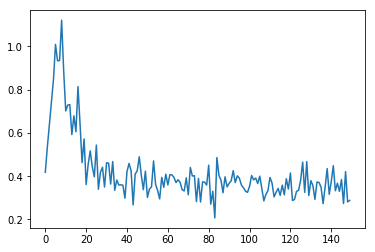

In [32]:
import matplotlib.pyplot as plt

plt.plot(eval_losses)
plt.show()

In [34]:
noise = torch.randn(train.shape[0], nz).to(device)
noisev = Variable(noise)
fake = netG_tr(noisev)

In [35]:
fake.shape

torch.Size([6040, 3706])

In [36]:
fake = np.around(fake.detach().cpu().numpy())

In [37]:
np.unique(fake)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.],
      dtype=float32)

In [38]:
fake = fake * (fake <= 5).astype(int)

In [39]:
print(5, (5 == fake.round()).sum(), (5 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(4, (4 == fake.round()).sum(), (4 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(3, (3 == fake.round()).sum(), (3 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(2, (2 == fake.round()).sum(), (2 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(1, (1 == fake.round()).sum(), (1 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(0, (0 == fake.round()).sum(), (0 == (tr + vr)[:fake.shape[0], :].round()).sum())

5 1465021 226310
4 2819271 348971
3 2622931 261197
2 836925 107557
1 44763 56174
0 14595329 21384031


As we see there is a significant bias towards higher ratings

In [40]:
# networks
netD_augm = NetD().to(device)
netG_augm = NetG().to(device)
print(netD_augm)
print(netG_augm)
optimizerG = optim.RMSprop(netG_augm.parameters(), lr=lrG)
optimizerD = optim.RMSprop(netD_augm.parameters(), lr=lrD)
one = torch.FloatTensor([1]).to(device)
mone = (-1 * one).to(device)

NetD(
  (t1): Linear(in_features=3706, out_features=1024, bias=True)
  (b1): Linear(in_features=3706, out_features=1024, bias=True)
  (fc): Linear(in_features=2048, out_features=3706, bias=True)
)
NetG(
  (net): Sequential(
    (0): Linear(in_features=16, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): Sigmoid()
    (4): Dropout(p=0.5)
    (5): Linear(in_features=1024, out_features=3706, bias=True)
    (6): Sigmoid()
    (7): Dropout(p=0.6)
  )
)


In [41]:
noise = torch.randn(train.shape[0], nz).to(device)
noisev = Variable(noise)
fake = netG_augm(noisev)

In [42]:
print(5, (5 == fake.round()).sum(), (5 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(4, (4 == fake.round()).sum(), (4 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(3, (3 == fake.round()).sum(), (3 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(2, (2 == fake.round()).sum(), (2 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(1, (1 == fake.round()).sum(), (1 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(0, (0 == fake.round()).sum(), (0 == (tr + vr)[:fake.shape[0], :].round()).sum())

5 tensor(1752921, device='cuda:0') 226310
4 tensor(624216, device='cuda:0') 348971
3 tensor(93823, device='cuda:0') 261197
2 tensor(3141, device='cuda:0') 107557
1 tensor(1, device='cuda:0') 56174
0 tensor(13426588, device='cuda:0') 21384031


In [44]:
train_GAN(netD_augm, netG_augm, augmented_train)

Epoch number 1. my distance between random real and fake samples 27796.94921875
Epoch number 1. MSE distance between random real and fake samples 0.46380364894866943
Epoch number 3. my distance between random real and fake samples 33339.7890625
Epoch number 3. MSE distance between random real and fake samples 0.5964004993438721
Epoch number 5. my distance between random real and fake samples 35039.26953125
Epoch number 5. MSE distance between random real and fake samples 0.7198690176010132
Epoch number 7. my distance between random real and fake samples 54702.88671875
Epoch number 7. MSE distance between random real and fake samples 1.1715189218521118
Epoch number 9. my distance between random real and fake samples 32133.794921875
Epoch number 9. MSE distance between random real and fake samples 0.6946011185646057
Epoch number 11. my distance between random real and fake samples 48702.703125
Epoch number 11. MSE distance between random real and fake samples 1.0291062593460083
Epoch num

Epoch number 99. my distance between random real and fake samples 22288.869140625
Epoch number 99. MSE distance between random real and fake samples 0.3363337516784668
Epoch number 101. my distance between random real and fake samples 22992.205078125
Epoch number 101. MSE distance between random real and fake samples 0.3525981307029724
Epoch number 103. my distance between random real and fake samples 23430.234375
Epoch number 103. MSE distance between random real and fake samples 0.3511309027671814
Epoch number 105. my distance between random real and fake samples 25422.236328125
Epoch number 105. MSE distance between random real and fake samples 0.3868910074234009
Epoch number 107. my distance between random real and fake samples 24883.759765625
Epoch number 107. MSE distance between random real and fake samples 0.37296029925346375
Epoch number 109. my distance between random real and fake samples 27345.15234375
Epoch number 109. MSE distance between random real and fake samples 0.41

Epoch number 195. my distance between random real and fake samples 18432.5390625
Epoch number 195. MSE distance between random real and fake samples 0.2825202941894531
Epoch number 197. my distance between random real and fake samples 20937.763671875
Epoch number 197. MSE distance between random real and fake samples 0.315379798412323
Epoch number 199. my distance between random real and fake samples 26144.24609375
Epoch number 199. MSE distance between random real and fake samples 0.386090487241745
Epoch number 201. my distance between random real and fake samples 19612.2265625
Epoch number 201. MSE distance between random real and fake samples 0.2961622178554535
Epoch number 203. my distance between random real and fake samples 27350.72265625
Epoch number 203. MSE distance between random real and fake samples 0.4189007878303528
Epoch number 205. my distance between random real and fake samples 36302.46484375
Epoch number 205. MSE distance between random real and fake samples 0.531803

Epoch number 291. MSE distance between random real and fake samples 0.2762313187122345
Epoch number 293. my distance between random real and fake samples 22676.5703125
Epoch number 293. MSE distance between random real and fake samples 0.33846592903137207
Epoch number 295. my distance between random real and fake samples 27362.423828125
Epoch number 295. MSE distance between random real and fake samples 0.411761999130249
Epoch number 297. my distance between random real and fake samples 24244.328125
Epoch number 297. MSE distance between random real and fake samples 0.3624785244464874
Epoch number 299. my distance between random real and fake samples 25390.75
Epoch number 299. MSE distance between random real and fake samples 0.36495715379714966


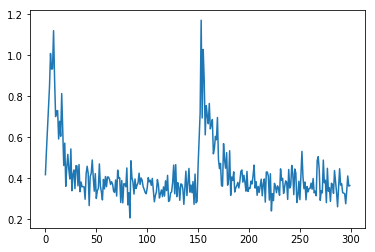

In [45]:
import matplotlib.pyplot as plt

plt.plot(eval_losses)
plt.show()

In [50]:
noise = torch.randn(train.shape[0], nz).to(device)
noisev = Variable(noise)
fake = netG_augm(noisev)

In [51]:
fake = np.around(fake.detach().cpu().numpy())

In [52]:
np.unique(fake)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.],
      dtype=float32)

In [53]:
fake = fake * (fake <= 5).astype(int)

In [54]:
print(5, (5 == fake.round()).sum(), (5 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(4, (4 == fake.round()).sum(), (4 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(3, (3 == fake.round()).sum(), (3 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(2, (2 == fake.round()).sum(), (2 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(1, (1 == fake.round()).sum(), (1 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(0, (0 == fake.round()).sum(), (0 == (tr + vr)[:fake.shape[0], :].round()).sum())

5 1436913 226310
4 2788828 348971
3 2627194 261197
2 849886 107557
1 45757 56174
0 14635662 21384031


In [55]:
noise = torch.randn(train.shape[0], nz).to(device)
noisev = Variable(noise)

fake_tr = netG_tr(noisev)
fake_aug = netG_augm(noisev)

In [57]:
print(5, (5 == fake_tr.round()).sum(), (5 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(4, (4 == fake_tr.round()).sum(), (4 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(3, (3 == fake_tr.round()).sum(), (3 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(2, (2 == fake_tr.round()).sum(), (2 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(1, (1 == fake_tr.round()).sum(), (1 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(0, (0 == fake_tr.round()).sum(), (0 == (tr + vr)[:fake.shape[0], :].round()).sum())

5 tensor(1462331, device='cuda:0') 226310
4 tensor(2819034, device='cuda:0') 348971
3 tensor(2621625, device='cuda:0') 261197
2 tensor(837891, device='cuda:0') 107557
1 tensor(44331, device='cuda:0') 56174
0 tensor(13432479, device='cuda:0') 21384031


In [58]:
print(5, (5 == fake_aug.round()).sum(), (5 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(4, (4 == fake_aug.round()).sum(), (4 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(3, (3 == fake_aug.round()).sum(), (3 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(2, (2 == fake_aug.round()).sum(), (2 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(1, (1 == fake_aug.round()).sum(), (1 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(0, (0 == fake_aug.round()).sum(), (0 == (tr + vr)[:fake.shape[0], :].round()).sum())

5 tensor(1436910, device='cuda:0') 226310
4 tensor(2791855, device='cuda:0') 348971
3 tensor(2625343, device='cuda:0') 261197
2 tensor(848793, device='cuda:0') 107557
1 tensor(45754, device='cuda:0') 56174
0 tensor(13430978, device='cuda:0') 21384031


In [ ]:
# tr_orig, vr_1 = loadData('./ml-1m/ratings.dat', delimiter='::', seed=seed,  transpose=False, valfrac=0.1)

In [ ]:
import nbimporter 
import matrix_factorization

In [ ]:
y

In [ ]:
iter_array = [1, 2, 5, 10, 25, 40]
MF_SGD = matrix_factorization.ExplicitMF(train.cpu().numpy(), 40, learning='sgd', verbose=True)
# iter_array = [1, 2, 5, 10, 25, 50, 100, 200]

# iter_array = [10]
# iter_array = [1, 2, 5, 10, 25]
MF_SGD.calculate_learning_curve(iter_array, vr, learning_rate=0.001)

In [ ]:
iter_array = [1, 2, 5, 10, 25, 40]
MF_SGD = matrix_factorization.ExplicitMF(aug_train, 40, learning='sgd', verbose=True)
# iter_array = [1, 2, 5, 10, 25, 50, 100, 200]

# iter_array = [10]
# iter_array = [1, 2, 5, 10, 25]
MF_SGD.calculate_learning_curve(iter_array, vr, learning_rate=0.001)

In [ ]:
rand_ix = np.random.randint(0, fake.shape[0], 300)

In [ ]:
adding_fake = fake[rand_ix,:]

In [ ]:
adding_fake

In [ ]:
tr = np.append(aug_train.cpu().numpy(), adding_fake, axis=0)

In [ ]:
iter_array = [1, 2, 5, 10, 25, 40]
MF_SGD = matrix_factorization.ExplicitMF(tr, 40, learning='sgd', verbose=True)
# iter_array = [1, 2, 5, 10, 25, 50, 100, 200]

# iter_array = [10]
# iter_array = [1, 2, 5, 10, 25]
MF_SGD.calculate_learning_curve(iter_array, vr, learning_rate=0.001)

In [ ]:
iter_array = [1, 2, 5, 10, 25, 40]
MF_SGD = matrix_factorization.ExplicitMF(tr, 40, learning='sgd', verbose=True)
# iter_array = [1, 2, 5, 10, 25, 50, 100, 200]

# iter_array = [10]
# iter_array = [1, 2, 5, 10, 25]
MF_SGD.calculate_learning_curve(iter_array, vr, learning_rate=0.001)

In [ ]:
aug_train = torch.Tensor(aug_train).float().to(device)

In [ ]:
steps_per_epoch = 300
gen_iterations = 0
eval_losses = []
epochs = 300
for epoch in range(epochs):
#     data_iter = iter(data_loader)
    i = 0
    while i < steps_per_epoch:
        ############################
        # (1) Update D network
        ###########################
        for p in netD.parameters(): # reset requires_grad
            p.requires_grad = True # they are set to False below in netG update
        d_iter = d_iter
        j = 0
        while j < d_iter*5:
            j += 1
            # load real data
            i += 1
#             X, _ = data_iter.next()
            X = get_random_batch(aug_train, batch_size=batch_size)
#             X += torch.Tensor(np.random.normal(0, 0.2, X.shape))
#             print(X >= 0.5)
# #             X = X.view(X.size(0), -1)
#             X = (X >= 0.5).float()
            if cuda: 
                X = X.cuda()
            real = Variable(X)
            # generate fake data
            noise = torch.randn(batch_size, nz)
            if cuda: 
                noise = noise.cuda()
            with torch.no_grad():
                noisev = Variable(noise) # totally freeze netG
            fake = Variable(netG(noisev).data)
#             print(real[0,:20], fake[0,:20])
            real + fake * (real == 0).float()
            fake = fake * Variable(real != 0).float().cuda()
#             real + fake * (real == 0).float()
#             print(real[0,:20], fake[0,:20])
            fake.requires_grad = False
#             print(real.shape, fake.shape)
    
            # compute gradient, take step
            netD.zero_grad()
#             print('real', real[:10, :20])
#             print('fake', fake[:10, :20])
#             print(real.type(), fake.type())
#             print(fake)
            out = netD(real, fake)
            
            outputD = torch.mean(out) + lamba * out.norm()
            stdD = torch.std(out)
            outputD.backward(mone)
            optimizerD.step()
#             print(out.shape)
        ############################
        # (2) Update G network
        ###########################
        g_iter = g_iter
        j = 0
        while j < g_iter*5:
            j += 1
            for p in netD.parameters():
                p.requires_grad = False # to avoid computation
            netG.zero_grad()
            
            # load real data
            i += 1
            X = get_random_batch(aug_train, batch_size=batch_size)
#             X += torch.Tensor(np.random.normal(0, 0.2, X.shape))
#             X = X.view(X.size(0), -1)
#             X = (X >= 0.5).float()
            if cuda: 
                X = X.cuda()
            real = Variable(X)
            
            # update generator
            noise = torch.randn(batch_size, nz)
            if cuda: 
                noise = noise.cuda()
            noisev = Variable(noise)
            
            fake = netG(noisev)
            real + fake * (real == 0).float()
            fake = fake * Variable(real != 0).float().cuda()
#             fake = fake * Variable(real != 0).float().cuda()
#             fake.requires_grad = False
#             fake = Variable(netG(noisev)).data
#             fake = fake * Variable(((real != 0) & (fake > 0.8))).float().cuda()
#             fake.requires_grad = True
            
            out = netD(real, fake)
            outputG = torch.mean(out) + lamba * out.norm()
            stdG = torch.std(out)
            outputG.backward(one)
            optimizerG.step()

            gen_iterations += 1

#             print('[%d/%d][%d/%d][%d] Loss_D: %f Loss_G: %f '% (epoch, epochs, i, len(data_loader), gen_iterations, outputD.item(), outputG.item()))
#             print('output_D', outputD.item(), gen_iterations)
#             print('output_G', outputG.item(), gen_iterations)
#             print('std_D', stdD.item(), gen_iterations)
#             print('std_G', stdG.item(), gen_iterations)
            torch.save(netG.state_dict(), './netG-1m')
            torch.save(netD.state_dict(), './netD-1m')
            # evaluation
            if gen_iterations % 100 == 0: # todo- to change
#                 gen.eval()
#                 z_vector_eval = make_some_noise(128)
#                 fake_rows_eval = gen(z_vector_eval)
#                 real_rows_eval = get_random_batch(train, 128)
        #         print(fake_rows[0][:10]) enable to see some results
#                 fake = Variable(netG(noisev).data).round()
#                 fake = ((real != 0) & (fake != 0))
#                 print(fake)
                eval_loss = F.mse_loss(fake, real, reduction='mean')
                eval_losses.append(eval_loss)
                print('Epoch number {}. my distance between random real and fake samples {}'.format(epoch, d_my(real, fake)))
                print('Epoch number {}. MSE distance between random real and fake samples {}'.format(epoch, eval_loss))

In [ ]:
tr = np.append(aug, adding_fake, axis=0)

In [ ]:
iter_array = [1, 2, 5, 10, 25, 40]
MF_SGD = matrix_factorization.ExplicitMF(tr, 40, learning='sgd', verbose=True)
# iter_array = [1, 2, 5, 10, 25, 50, 100, 200]

# iter_array = [10]
# iter_array = [1, 2, 5, 10, 25]
MF_SGD.calculate_learning_curve(iter_array, vr, learning_rate=0.001)

In [ ]:
train > 3 

In [ ]:
get_sparsity(train > 3)

In [ ]:
(train[0,:] > 3).sum()

In [ ]:
train

In [ ]:
train = torch.Tensor(tr.copy()).to(device)

In [ ]:
get_sparsity(train.cpu().numpy())

In [ ]:
train > 3

In [ ]:
zero_mask = (train == 0).to(device).float()

In [ ]:
positive_feedback_mask = (train > 3).to(device).float()

In [ ]:
negative_feedback_mask = ((train < 4).to(device).float() * (1 - zero_mask)).to(device).float()

In [ ]:
((positive_feedback_mask + negative_feedback_mask) != zero_mask).all()

In [ ]:
get_sparsity(negative_feedback_mask.cpu().numpy())

In [ ]:
# class denoising_autoencoder(nn.Module):
#     def __init__(self, n_users, input_size, z=256):
#         ''' 
#         mimic the network architecture from the paper
#         '''
#         super(denoising_autoencoder, self).__init__()
        
#         self.V = torch.FloatTensor(n_users, z).to(device)
#         self.b = torch.FloatTensor(n_users, 1).to(device)
#         self.b_shtrix = torch.FloatTensor(n_users, 1).to(device)
    
#         self.encoder = nn.Linear(input_size, z)
#         self.decoder = nn.Linear(z, input_size)
        
#         torch.nn.init.xavier_uniform_(self.encoder.weight)
#         torch.nn.init.xavier_uniform_(self.encoder.weight)
 
#     def forward(self, x, i):
#         z = self.encoder(x)
#         z = z + self.V[i, :] + self.b[i, :] 
#         z = torch.nn.functional.relu(z)
#         x = self.decoder(z)
#         x = x + self.b_shtrix[i, :]
#         return torch.sigmoid(x)


# # class denoising_autoencoder(nn.Module):
# #     def __init__(self, n_users, input_size, z=256):
# #         super(denoising_autoencoder, self).__init__()
        
# # #         torch.nn.init.xavier_uniform(self.V)
# # #         torch.nn.init.xavier_uniform(self.b.weight)
# # #         torch.nn.init.xavier_uniform(self.b_shtrix.weight)

# #         self.encoder=nn.Sequential(
# #                       nn.Linear(input_size, 1024),
# #                       nn.Dropout(0.4),
# #                       nn.ReLU(),
# #                       nn.Linear(1024,512),
# #                       nn.Dropout(0.6),
# #                       nn.ReLU(),
# #                       nn.Linear(512, z),
# # #                       nn.Sigmoid()
# #                       )

# #         self.decoder=nn.Sequential(
# #                       nn.Linear(z, 512),
# #                       nn.Dropout(0.4),
# #                       nn.ReLU(),
# #                       nn.Linear(512, 1024),
# #                       nn.Dropout(0.6),
# #                       nn.ReLU(),
# #                       nn.Linear(1024, input_size),
# # #                       nn.Sigmoid(),
# #                       )
        
# #         self.init_weights()
    
# #     def init_weights(self):

# #         for l, ll in zip(self.encoder, self.decoder):
# #             if type(l) == torch.nn.Linear:
# #                 torch.nn.init.xavier_uniform_(l.weight)
# #             if type(ll) == torch.nn.Linear:
# #                 torch.nn.init.xavier_uniform_(ll.weight)

# #     def forward(self, x, i):
# #         z = self.encoder(x)
# #         x = self.decoder(z)
    
# #         return x

In [ ]:
# model = denoising_autoencoder(input_size=train[0,:].shape[0], n_users=train.shape[0]).to(device)
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

In [ ]:
# model

In [ ]:
def get_random_batch(orig_mat, corrupted_mat, batch_size = 64):
    '''
    This works as a trainloader for denoising autoencoder.
    Randomly masks observed entries (replaces 1s with 0s) to add a noise
    '''
    rand_rows = np.random.randint(orig_mat.shape[0], size=batch_size)
#     print(rand_rows)
#     return mat[rand_rows], mat[rand_rows]
    orig = orig_mat[rand_rows].clone()
    corrupted = corrupted_mat[rand_rows].clone()

    return orig, corrupted, rand_rows

In [ ]:
def get_random_masked_batch(mat, batch_size = 32, p=0.5):
    '''
    This works as a trainloader for denoising autoencoder.
    Randomly masks observed entries (replaces 1s with 0s) to add a noise
    '''
    rand_rows = np.random.randint(mat.shape[0], size=batch_size)
#     print(rand_rows)
#     return mat[rand_rows], mat[rand_rows]
    orig = mat[rand_rows].clone()
    corrupted = mat[rand_rows].clone()
    mask_arr = torch.FloatTensor((np.random.rand(orig.shape[0], orig.shape[1]) > p)).to(device)

    return orig, corrupted*mask_arr, rand_rows

orig, masked, _ = get_random_masked_batch(negative_feedback_mask)

In [ ]:
get_sparsity(orig.cpu().numpy())

In [ ]:
get_sparsity(masked.cpu().numpy())

In [ ]:
P = 0.4
mask_arr = torch.FloatTensor((np.random.rand(negative_feedback_mask.shape[0], negative_feedback_mask.shape[1]) > P)).to(device)
y = negative_feedback_mask
X = negative_feedback_mask*mask_arr

In [ ]:
get_sparsity(X.cpu().numpy()), get_sparsity(y.cpu().numpy())

In [ ]:
losslist = []
model.train()
def train_den_ae(mat,epochs= 400,steps_per_epoch = 300, _unsqueeze=True):
    epochloss = 0
    running_loss = 0
    steps_per_epoch = 1000

    for epoch in range(epochs):

        for i in range(steps_per_epoch):
            orig, masked, idxs = get_random_batch(y, X, batch_size=batch_size)

            if _unsqueeze:
                masked = masked.unsqueeze(2)
            output = model(masked, idxs)
            loss = criterion(output, orig)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if i%20 == 0:
                running_loss += loss.item()
                epochloss += loss.item()
                losslist.append(loss.item())
                running_loss=0
                print("======> epoch: {}/{}, Loss:{}".format(epoch,epochs,loss.item()))
                
train_den_ae(negative_feedback_mask, _unsqueeze=False)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losslist)
plt.show()

In [ ]:
orig, masked, _ = get_random_masked_batch(negative_feedback_mask, batch_size=1, p=0.5)

In [ ]:
(orig[0][:400] > 0).sum(), (masked[0][:400] > 0).sum()

In [ ]:
orig[0][:100]

In [ ]:
masked[0][:100]

In [ ]:
model.eval()

In [ ]:
#-----------------Forward Pass----------------------
output = model(masked, _)

In [ ]:
(masked[0] >0.8).sum()

In [ ]:
(output[0] >0.2).sum()

In [ ]:
masked[0][0:100]

In [ ]:
output[0][0:100]

In [ ]:
orig, masked, _ = get_random_masked_batch(negative_feedback_mask, batch_size=1)

In [ ]:
orig[0][:400]

In [ ]:
masked[0][:400]

In [ ]:
#-----------------Forward Pass----------------------
output = model(masked)

In [ ]:
orig[0][:400](orig.round() > 0).sum()

In [ ]:
(masked.round() > 0).sum()

In [ ]:
(output.round() > 0).sum()

In [ ]:
output.round()[0,100:400]

In [ ]:
orig[0,100:400]

In [ ]:
# class conv_denoising_autoencoder(nn.Module):

#     def __init__(self, inSize,fSize = 32, nz=24):  #sigma is the corruption level
#         super(conv_denoising_autoencoder, self).__init__()
#         #define layers here

#         self.inp_size = inSize
#         self.nz = nz
#         self.fSize = 32
# #         self.imSize = imSize
# #         self.sigma = sigma
# #         self.multimodalZ = multimodalZ

# #         inSize = imSize / ( 2 ** 4)
# #         self.inSize = inSize
    
#         self.enc1 = nn.Conv1d(self.inp_size, fSize, 5, stride=2, padding=2)
#         self.enc2 = nn.Conv1d(fSize, fSize * 2, 5, stride=2, padding=2)
#         self.enc3 = nn.Conv1d(fSize * 2, fSize * 4, 5, stride=2, padding=2)
#         self.enc4 = nn.Conv1d(fSize * 4, fSize * 8, 5, stride=2, padding=2)
#         self.enc5 = nn.Linear(fSize * 8, self.nz)

#         self.dec1 = nn.Linear(self.nz, fSize * 8)
#         self.dec2 = nn.ConvTranspose1d(fSize * 8, fSize * 4, 3, stride=2, padding=1, output_padding=1)
#         self.dec3 = nn.ConvTranspose1d(fSize * 4, fSize * 2, 3, stride=2, padding=1, output_padding=1)
#         self.dec4 = nn.ConvTranspose1d(fSize * 2, fSize, 3, stride=2, padding=1, output_padding=1)
#         self.dec5 = nn.ConvTranspose1d(fSize, 32, 3, stride=2, padding=1, output_padding=1)
#         self.last_dec = nn.Linear(32*16, self.inp_size)
        
#         self.useCUDA = torch.cuda.is_available()

# #     def norm_prior(self, noSamples=25):
# #         z = torch.randn(noSamples, self.nz)
# #         return z

# #     def multi_prior(self, noSamples=25, mode=None):
# #         #make a 2D sqrt(nz)-by-sqrt(nz) grid of gaussians
# #         num = np.sqrt(self.nz) #no of modes in x and y
# #         STD = 1.0
# #         modes = np.arange(-num,num)
# #         p = np.random.uniform(0, num,(noSamples*2))

# #         if mode is None:
# #             mu = modes[np.floor(2 * p).astype(int)]
# #         else:
# #             mu = modes[np.ones((noSamples, 2), dtype=int) * int(mode)]

# #         z = torch.Tensor(mu).view(-1,2) + STD * torch.randn(noSamples, 2)
# #         return z

#     def encode(self, x):
#         self.batch_size = x.shape[0]
#         #define the encoder here return mu(x) and sigma(x)
#         x = F.relu(self.enc1(x))
#         x = F.relu(self.enc2(x))
#         x = F.relu(self.enc3(x))
#         x = F.relu(self.enc4(x))
#         x = x.view(x.size(0), -1)
#         x = self.enc5(x)

#         return x

# #     def corrupt(self, x):
# #         noise = self.sigma * Variable(torch.randn(x.size())).type_as(x)
# #         return x + noise

# #     def sample_z(self, noSamples=25, mode=None):
# #         if not self.multimodalZ:
# #             z = self.norm_prior(noSamples=noSamples)
# #         else:
# #             z = self.multi_prior(noSamples=noSamples, mode=mode)
# #         if self.useCUDA:
# #             return Variable(z.cuda())
# #         else:
# #             return Variable(z)

#     def decode(self, z):
#         #define the decoder here
#         z = F.relu(self.dec1(z))
#         z = z.unsqueeze(2)
# #         print(z.shape)
# #         z = z.view(z.size(0), -1, self.inp_size)
#         z = F.relu(self.dec2(z))
#         z = F.relu(self.dec3(z))
#         z = F.relu(self.dec4(z))
#         z = F.sigmoid(self.dec5(z))
# #         print(z.shape)
# #         z = F.sigmoid(self.last_dec(z.view(self.batch_size, -1)))
#         z = F.sigmoid(self.last_dec(z.view(self.batch_size, -1)))
    
#         return z

#     def forward(self, x):
#         # the outputs needed for training
# #         x_corr = self.corrupt(x)
#         z = self.encode(x)
#         return self.decode(z)

In [ ]:
model = conv_denoising_autoencoder(train[0,:].shape[0]).to(device)
criterion = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters(),lr=0.01, weight_decay=1e-5)

In [ ]:
steps_per_epoch = 500
train_den_ae(negative_feedback_mask, steps_per_epoch=steps_per_epoch, _unsqueeze=True)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losslist)
plt.show()

In [ ]:
orig, masked, _ = get_random_masked_batch(negative_feedback_mask, batch_size=64)

In [ ]:
(orig[0][:400] > 0).sum(), (masked[0][:400] > 0).sum()

In [ ]:
orig[0][:400]

In [ ]:
masked[0][:400]

In [ ]:
#-----------------Forward Pass----------------------
output = model(masked.unsqueeze(2))

In [ ]:
output.shape

In [ ]:
((output[7]).round() >0).sum()

In [ ]:
for i in range(output.shape[0]):
    print(((output[i]).round() >0).sum())

In [ ]:
((output).round() >= 1 ).sum()

In [ ]:
(output).round()[0][2000:3000]

In [ ]:
(output > 0.5).sum()

In [ ]:
!git clone https://github.com/gtshs2/Collaborative-Denoising-Auto-Encoder

In [ ]:
((tr + vr) > 0).sum()

In [ ]:
from keras.optimizers import Adam
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras import regularizers

def autoEncoder(X):
    '''
    Autoencoder for Collaborative Filter Model
    '''

    # Input
    input_layer = Input(shape=(X.shape[1],), name='UserScore')
    
    # Encoder
    # -----------------------------
    enc = Dense(512, activation='selu', name='EncLayer1', kernel_regularizer=regularizers.l2(0.000001))(input_layer)

    # Latent Space
    # -----------------------------
    lat_space = Dense(512, activation='selu', name='LatentSpace', kernel_regularizer=regularizers.l2(0.000001))(enc)
    lat_space = Dropout(0.5, name='Dropout')(lat_space) # Dropout

    # Decoder
    # -----------------------------
    dec = Dense(512, activation='selu', name='DecLayer1', kernel_regularizer=regularizers.l2(0.000001))(lat_space)

    # Output
    output_layer = Dense(X.shape[1], activation='linear', name='UserScorePred', kernel_regularizer=regularizers.l2(0.000001))(dec)

    # this model maps an input to its reconstruction
    model = Model(input_layer, output_layer)    
    
    return model

In [ ]:
mask_arr = torch.FloatTensor((np.random.rand(negative_feedback_mask.shape[0], negative_feedback_mask.shape[1]) > 0.4)).to(device)

In [ ]:
mask_arr = torch.FloatTensor((np.random.rand(negative_feedback_mask.shape[0], negative_feedback_mask.shape[1]) > 0.4)).to(device)
y = negative_feedback_mask.cpu().numpy()
X = (negative_feedback_mask*mask_arr).cpu().numpy()

In [ ]:
get_sparsity(y), get_sparsity(X)

In [ ]:
model = autoEncoder(X)

model.compile(optimizer = Adam(lr=0.0001), loss='mse')
    
model.summary()

In [ ]:
hist = model.fit(x=X, y=y,
                  epochs=300,
                  batch_size=128,
                  shuffle=True,
                  validation_split=0.0)

In [ ]:
def plot_hist(hist):
    # summarize history for loss
    fig, ax = plt.subplots()  # create figure & 1 axis

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    plt.plot(hist.history['loss'])
    #plt.plot(hist.history['val_loss'])

plot_hist(hist)

In [ ]:

# Predict new Matrix Interactions, set score zero on visualized games
# new_matrix = model.predict(X) * (X == 0)
new_matrix = model.predict(X)

In [ ]:
# # converting the reconstructed matrix back to a Pandas dataframe
# new_users_items_matrix_df  = pd.DataFrame(new_matrix, 
#                                           columns = users_items_matrix_df.columns, 
#                                           index   = users_items_matrix_df.index)
# new_users_items_matrix_df.head()

new_matrix

In [ ]:
torch.set_printoptions(precision=3)

In [ ]:
np.set_printoptions(precision=3)

In [ ]:
(new_matrix>0.4).sum() # predicted

In [ ]:
(X>0.5).sum() # trained on

In [ ]:
(y > 0.99).sum() # actual

In [ ]:
(y * (new_matrix>0.4) == 1).sum()/(new_matrix>0.4).sum() # accuracy on actual 

In [ ]:
(y * (new_matrix>0.5)).sum()/((new_matrix>0.5).sum())

In [ ]:
(y * (new_matrix>0.5)).sum()/((new_matrix>0.5).sum())

In [ ]:
((y * (((new_matrix>0.8)  * (X<0.5)))) == 1).sum()/(((new_matrix>0.8)  * (X<0.5))).sum()

In [ ]:
new_matrix_2 = model.predict(y)

In [ ]:
(new_matrix_2>0.5).sum()

In [ ]:
((y* (((new_matrix_2>0.5)) == 1))).sum()/(((new_matrix_2>0.5)).sum())

In [ ]:
np.set_printoptions(suppress=True)
np.set_printoptions(precision=1)
new_matrix[:20, :20]

In [ ]:
y[:20, :20]

In [ ]:
(new_matrix_2>0.3).sum()

In [ ]:
(new_matrix>0.5).sum()

In [ ]:
(new_matrix_2 > 0.3).sum()

In [ ]:
(y > 0.5).sum()

In [ ]:
threshold = 0.4

In [ ]:
((new_matrix_2 > threshold).astype(float) * (train > 0).cpu().numpy().astype(float)).sum()

In [ ]:
((new_matrix_2 > threshold).astype(float) * (train == 0).cpu().numpy().astype(float)).sum() # new values

In [ ]:
delta = 3 # delta could be 1,2,3

In [ ]:
(((train > 0).cpu().numpy().astype(float) > 0) *(new_matrix_2 > threshold).astype(float) * (train == 0).cpu().numpy().astype(float)).sum() # checking

In [ ]:
augmented_train = train.cpu().numpy().astype(float) + delta * (new_matrix_2 > threshold).astype(float) * (train == 0).cpu().numpy().astype(float)

In [ ]:
get_sparsity(train.cpu().numpy())

In [ ]:
get_sparsity(augmented_train)

In [ ]:
p_probs = [(train == 1).sum().item()/((train > 0) & (train < 4)).sum().item(), (train == 2).sum().item()/(((train > 0) & (train < 4))).sum().item(), (train == 3).sum().item()/((train > 0) & (train < 4)).sum().item()]
p_probs

In [ ]:
(train == 1).sum().item()/((train > 0) & (train < 4)).sum().item() + (train == 2).sum().item()/(((train > 0) & (train < 4))).sum().item() + (train == 3).sum().item()/((train > 0) & (train < 4)).sum().item()

In [ ]:
np.random.randint(1,4, 10)

In [ ]:
del augmented_train

In [ ]:
np.random.choice(np.arange(1, 4), train.shape, p=p_probs)

In [ ]:
((train > 0).cpu().numpy().astype(float)  * (new_matrix_2 > threshold).astype(float) * (train == 0).cpu().numpy().astype(float)*np.random.choice(np.arange(1, 4), train.shape, p=p_probs)).sum() # should be zero

In [ ]:
aug_train = train.cpu().numpy().astype(float) + (new_matrix_2 > threshold).astype(float) * (train == 0).cpu().numpy().astype(float)*np.random.choice(np.arange(1, 4), train.shape, p=p_probs)

In [ ]:
(aug_train > 0).sum()

In [ ]:
get_sparsity(aug_train)